# Digital homodyne detection and state tomography
State tomography with convex optimization.

In [1]:
import matplotlib.pyplot as plt
import cvxpy as cp
import numpy as np

from qutip import *

from scipy.special import factorial, eval_hermite
from scipy.integrate import quad
from joblib import Parallel, delayed

## Define basic operators

In [2]:
N = 15 # Fock space dimension

idc = qeye(N) # identity on cavity Hilbert space
ida = qeye(2) # identity on qubit Hilbert space

a  = tensor(destroy(N), ida) # cavity annilitation operator
sm = tensor(idc, destroy(2)) # qubit annihilation operator

# qubit Pauli sigma operators
sx = tensor(idc, sigmax()) 
sy = tensor(idc, sigmay())
sz = tensor(idc, sigmaz())

# projector onto qubit ground state
proj0 = tensor(idc, basis(2,0).proj())

# projector onto qubit excited state
proj1 = tensor(idc, basis(2,1).proj())

## Define unitaries

In [3]:
# Rotation around Bloch sphere x-axis by angle theta
def rotateX(theta):
    op = (-1j) * (theta/2) * sx
    return op.expm()

# Rotation around Bloch sphere y-axis by angle theta
def rotateY(theta):
    op = (-1j) * (theta/2) * sy
    return op.expm()

# Rotation around Bloch sphere x- and y-axes. 
# Used for projecting z onto Bloch sphere equator plane and choosing quadrature
def rotateXY(theta,rotangl):
    op = (-1j) * (theta/2) * (np.cos(rotangl)* sx + np.sin(rotangl)* sy)
    return op.expm()

# interaction unitary with effective strength g_int
def U_int(g_int):
    Hint = (-1j) * g_int* (a.dag() * sm + a * sm.dag())
    return Hint.expm()

## Parameters and initial state

0.15707963267948966

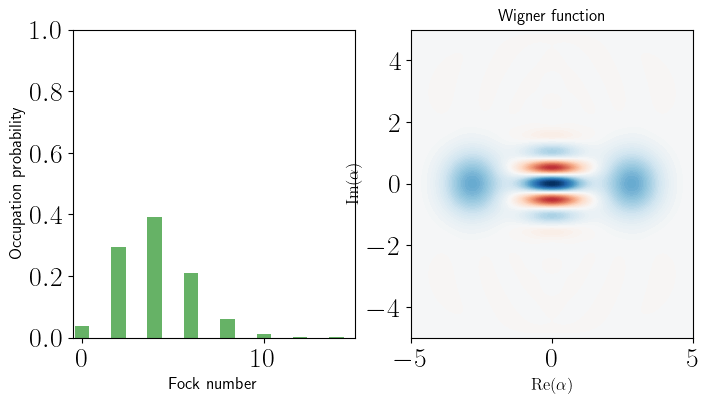

In [4]:
# number of qubit measurements per trajectory
Nmeas = 200

# number of trajectories
Ntrajs = 1000

# interaction strength
g = 4 # MHz 
delta_t = 0.005 # µs

gamma = g**2  # effective decay rate given by squared physical coupling strength

# effective interaction strength
gint = np.sqrt(gamma*delta_t)


# "manually" set interaction strength
gint = 0.1*np.pi/2 # 0.1 SWAP


# set initial cavity state
alphain = 2
initial_cavity = (coherent(N, alphain) + coherent(N,-alphain)).unit()
#initial_cavity= coherent(N, alphain)
#initial_cavity=fock(N,2)

# initial state, qubit in ground state
psi0 = tensor(initial_cavity, basis(2,0))


plot_wigner_fock_distribution(initial_cavity, alpha_max=5)
gint

## Homodyne detection

### Homodyne settings

In [5]:
# homodyne angles
nangles = 10 # number of angles
thetas = np.linspace(0,np.pi, nangles) # list of all angles

# histogram parameters
Nbins = 60 # number of histogram bins
L = 5  # bin edge limit
dx =  2*L/Nbins # bin width

### Weight function

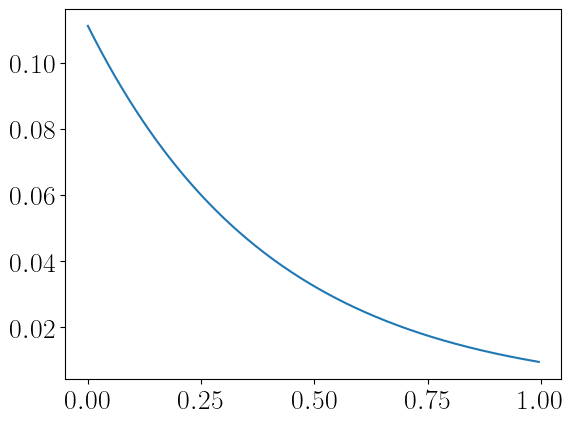

In [6]:
# weight measurement results with exponential filter
nsteps = np.linspace(0,Nmeas-1,Nmeas)

weights=(gint/np.sqrt(2))*np.exp(-nsteps*(gint**2/2))

plt.plot(delta_t*nsteps, weights);

### Simulate homodyne detection

In [7]:
# interaction unitary
Uint = U_int(gint)

# get measurement histogram for one homodyne angle
def get_hist(rotangl):
        
    qbrotmat = rotateXY(np.pi/2,rotangl) # qb rotation applied prior to qb measurement, defines measured homodyne quadrature
    
    qbfeedback = rotateX(np.pi) # this pulse will reset the qubit if found in the excited state
    measurements = [] # initiate list to store measurement results

    for j in range(Ntrajs): # do Ntrajs trajectories
        xrnd = np.random.rand(Nmeas)
    
        results = [] # store results for one trajectory
        psi = psi0

        # perform qubit measurements
        for i in range(Nmeas):
            psi = qbrotmat * (Uint * psi)
            prob = expect(proj0,psi) # expectation value of qubit ground state

            # random measurement results
            if prob > xrnd[i]:
                # measured g
                results.append(-1)
                psi = (proj0 * psi).unit() # project qubit to ground state
            else:
                results.append(1)
                # measured e
                psi = (proj1 * psi).unit()
                # go back to g
                psi = qbfeedback * psi

        # store weigthed measurement results
        measurements.append(np.sum(results*weights))
    
    
    ### create histogram ###    
    hist, bins, _ = plt.hist(measurements,Nbins,[-L,L], density=True, alpha=0.5, edgecolor='k')
    return hist   

In [8]:
# get histograms for all angles in parallell
# NOTE: multiprocessing backend can give duplicate measurement results. loky should be ok though
# https://joblib.readthedocs.io/en/latest/auto_examples/parallel_random_state.html

b_all = Parallel(n_jobs=nangles, verbose=1, backend="loky")(delayed(get_hist)(rotangle) for rotangle in thetas)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:  1.4min remaining:  5.5min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:  1.6min finished


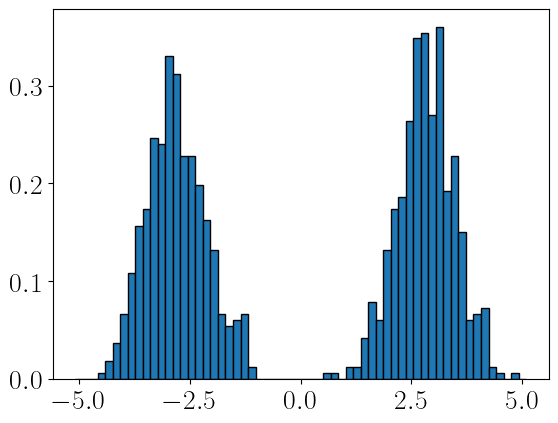

In [9]:
# plot one histogram for show

x_hist = np.linspace(-L,L,Nbins)
width = np.diff(x_hist)[0]
plt.bar(x_hist,b_all[0], align='center', width=width, edgecolor='k');

# Tomography

### Prepare data and operators

In [10]:
# Load homodyne data into vector $\vec b$
b = np.concatenate([array for array in b_all])

### Define the harmonic oscillator wavefunction
#To create homodyne POVM operators.

def wavefunction(x,n):
    const = 1/(np.sqrt(2**n * factorial(n)) * (np.pi)**0.25 )
    rest = const* np.exp(-x**2/2)
    return float(rest*eval_hermite(n,x))

### Construct operators

def get_Pis(theta, i):
    Pi = np.zeros((N,N),dtype=np.complex128)
    for m in range(N):
        wave_m = lambda x : wavefunction(x, m)
        for n in range(N):
            wave_n = lambda x: wavefunction(x, n)            
            func = lambda x: wave_m(x)*wave_n(x)
            Pi[n,m] = quad(func, -L + i*dx, -L + (i+1)*dx)[0]*np.exp(-1j*(n-m)*theta)
            
    return Pi*2 #

Pis = Parallel(n_jobs=16, verbose=0, backend="multiprocessing")(delayed(get_Pis)(theta,i) for theta in thetas for i in range(Nbins))

#The list `basis_dms` contains all $\Omega_k$
# construct vectors
basis_vectors = []
for i in range(N):
    vector = fock(N, i)
    basis_vectors.append(np.real(vector.full()))
    
# construct operators
basis_dms = []
for vector1 in basis_vectors:
    for vector2 in basis_vectors:
        dm = np.outer(vector1, vector2)
        basis_dms.append(dm)

### Construct the matrix A in $A\vec\rho=\vec b$
#From `Pis` and `basis_dms`.

def func(index, a):
    return np.trace(Pis[index[0]] @ basis_dms[index[1]])

A = np.zeros((len(Pis), N*N), dtype=np.complex64)
A_p = Parallel(n_jobs=16, verbose=0, backend="multiprocessing")(delayed(func)(idx,a) for idx, a in np.ndenumerate(A))

A = np.reshape(A_p, (len(Pis), N*N))

### Convex optimization

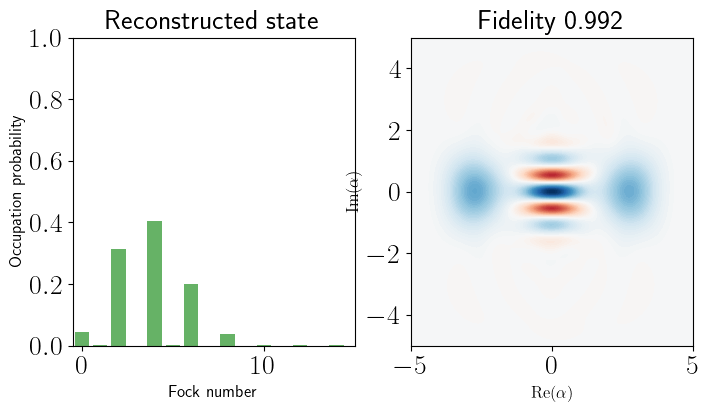

In [11]:
# Define the unknown state as a $N\times N$ Hermitian matrix

X = cp.Variable((N,N), hermitian=True)

#Set the cost function to $\|A\vec\rho - \vec b\|_2$ where the vectorized state is given by `cp.vec(X)`.

cost = cp.norm(A @ cp.vec(X) - b, 2) 

#Set the trace constraint and positive-semidefinite constraint
constraints = [cp.trace(X) == 1, X >> 0 ]

#Set up and solve the problem!

prob = cp.Problem(cp.Minimize(cost), constraints)
prob.solve(verbose=False, solver='SCS')

# Assign the optimized state X to a Qobj.
reconstructed_rho = Qobj(X.value)

### Visualize results

#Plot the reconstructed state 
alpha_max = 5
fig, ax = plot_wigner_fock_distribution(reconstructed_rho, alpha_max=5)
ax[0].set_title("Reconstructed state")

f=fidelity(reconstructed_rho, initial_cavity)**2
ax[1].set_title("Fidelity %.3f"%(f));

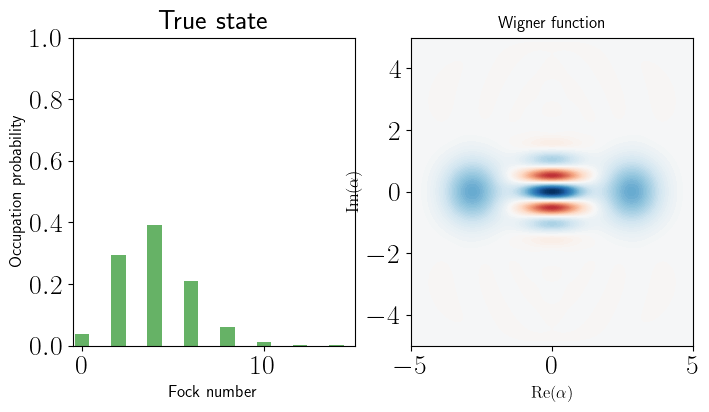

In [12]:
fig, ax = plot_wigner_fock_distribution(initial_cavity, alpha_max=5);
ax[0].set_title("True state");